In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 준비

In [4]:
# 패션 mnist 데이터 로드
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [8]:
# 이미지 입력시에는 채널에 대한 정보가 있어야 함
# 지금은 Conv2D를 적용하기 위해서 채널 차원을 추가
scaled_train = x_train.reshape(-1, 28, 28, 1) / 255

In [10]:
scaled_train.shape

(60000, 28, 28, 1)

# 2. 합성곱 신경망 모델 구성

1. 합성곱 층으로 이미지에서 특징을 감지
2. 밀집층으로 클래스에 따른 분류 확률을 계산

In [18]:
model = keras.Sequential()

In [20]:
# 입력층 추가
model.add(keras.Input(shape = (28, 28, 1)))

# 합성곱층 추가
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = "relu", padding = "same"))

- 패션 MNIST 데이터가 (28, 28) 크기에 세임 패딩을 적용, 32개의 필터 사용
    - 출력되는 특성맵의 크기는 (28, 28, 32)

In [23]:
# 풀링층 추가
model.add(keras.layers.MaxPool2D(2))

- (2, 2) 크기의 커널을 이용하여 풀링을 적용해서 특성맵의 크기가 절반으로 줄어들고 특성맵의 깊이는 그대로
    - 출력되는 특성맵의 크기는 (14, 14, 32)

In [26]:
# 두번째 합성곱 - 풀링층 추가
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = "relu", padding = "same"))
model.add(keras.layers.MaxPool2D(2))

- (14, 14) 크기에 세임 패딩, 64개 필터 적용
    - 출력되는 특성맵의 크기 (14, 14, 64)
- (2, 2) 크기의 커널을 이용하여 풀링
    - 출력되는 특성맵의 크기 (7, 7, 64)

In [29]:
# 3차원 특성맵을 일렬로 펼침
# 10개의 유닛을 가진 밀집층에서 확률을 계산하기 때문에
model.add(keras.layers.Flatten())

In [31]:
# 밀집 은닉층을 하나 더 추가한 후 드롭아웃을 넣어 과대적합을 방지하고 성능을 개선
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dropout(0.4))

In [33]:
# 출력층
# 10개의 클래스를 분류하는 다중 분류
model.add(keras.layers.Dense(10, activation = "softmax"))

In [35]:
# 모델 구조 확인
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

### 파라미터 개수

- 첫 번째 합성곱 층
    - 필터의 크기 : (3, 3, 1)
    - 필터의 개수 : 32
    - 3 * 3 * 1 * 32 + 32 = 320
- 두 번째 합성곱 층
    - 필터의 크기 : (3, 3, 32)
    - 필터의 개수 : 64
    - 3 * 3 * 32 * 64 + 64 = 18496
- 밀집 은닉 층
    - Flatten 층에서 (3136,) 크기의 배열이 전달 (7 * 7 * 64)
    - 3136 * 100 + 100 = 313700
- 출력층
    - 밀집 은닉 층에서 (100,) 크기의 배열이 전달
    - 100 * 10 + 10 = 1010

# 3. 모델 훈련

- 옵티마이저 : Adam
- 콜백함수 : ModelCheckpoint, EarlyStopping

In [41]:
cp_cb = keras.callbacks.ModelCheckpoint("./model/best-cnn-model.keras", save_best_only = True)
es_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [43]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [45]:
history = model.fit(scaled_train, y_train, epochs = 20, validation_split = 0.2, callbacks = [cp_cb, es_cb], batch_size = 32)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7470 - loss: 0.7278 - val_accuracy: 0.8794 - val_loss: 0.3376
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8673 - loss: 0.3729 - val_accuracy: 0.8978 - val_loss: 0.2818
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8884 - loss: 0.3093 - val_accuracy: 0.9013 - val_loss: 0.2656
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9036 - loss: 0.2672 - val_accuracy: 0.9039 - val_loss: 0.2579
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9107 - loss: 0.2486 - val_accuracy: 0.9107 - val_loss: 0.2351
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9173 - loss: 0.2231 - val_accuracy: 0.9168 - val_loss: 0.2263
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9254 - loss: 0.2026 - val_accuracy: 0.9148 - val_loss: 0.2363
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9300 - loss: 0

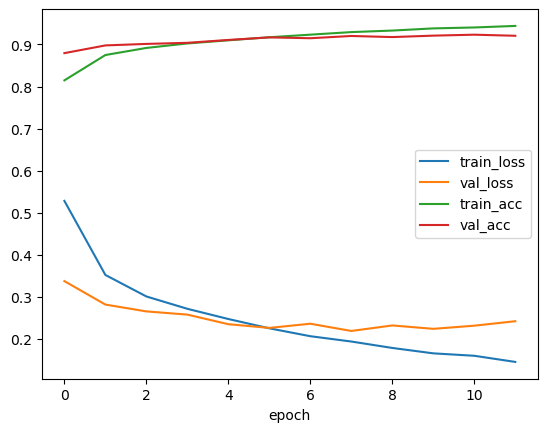

In [47]:
plt.figure()
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

# 4. 모델 성능 검증

In [50]:
scaled_test = x_test.reshape(-1, 28, 28, 1) / 255

In [52]:
model.evaluate(scaled_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9157 - loss: 0.2485


[0.24314819276332855, 0.9147999882698059]

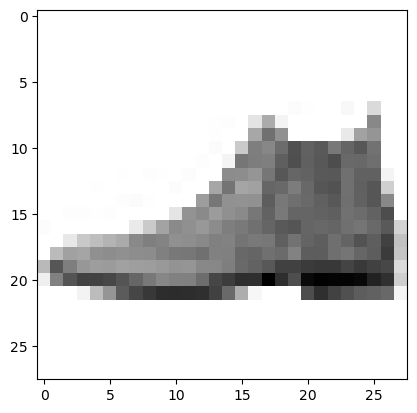

In [54]:
# 데이터 시각화
plt.imshow(scaled_test[0].reshape(28, 28), cmap = "gray_r")
plt.show()

In [56]:
preds = model.predict(scaled_test[[0]])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
[[2.1640457e-10 8.4966729e-17 2.6475122e-10 2.0579692e-12 4.1332246e-12
  3.9339889e-06 8.8968409e-11 1.8644163e-04 1.5905545e-12 9.9980968e-01]]


In [64]:
scaled_test[[0]].shape

(1, 28, 28, 1)

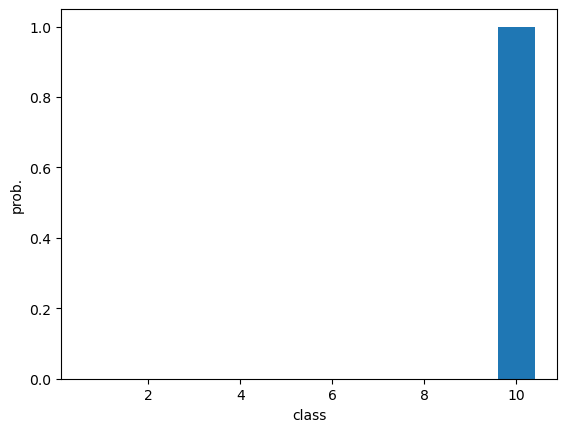

In [58]:
plt.figure()
plt.bar(range(1, 11), preds[0])
plt.xlabel("class")
plt.ylabel("prob.")
plt.show()

In [60]:
np.argmax(preds)

9

In [62]:
y_test[0]

9